<a href="https://colab.research.google.com/github/MonitSharma/Learn-Quantum-Machine-Learning/blob/main/Quantum_Models_as_Fourier_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Models as Fourier Series

This tutorial is based on the paper **The effect of data encoding on the expressive power of variational quantum machine learning models** by [Schuld, Sweke, and Meyer (2020)](https://arxiv.org/abs/2008.08605)

![](https://pennylane.ai/qml/_images/scheme_thumb.png)

The paper talks about common quantum machine learning models designed for near-term quantum computers to Fourier Series. 


## Background

Let's consider a quantum machine learning model of the form:
$$ f_{\boldsymbol \theta}(x) = \langle 0| U^{\dagger}(x,\boldsymbol \theta) M U(x, \boldsymbol \theta) | 0 \rangle $$

Where $M$ is the measurement observable and $U(x, \theta)$ is a variational quantum circuit that enocdes the data input $x$ and depends on a set of parameters $\theta$. We will currently work on $1-$D data.

------------
---------------


The circuit repeats itself $L$ layers, each consisting of a data-encoding block $S(x)$ and a trainable block $W(\theta)$ that is controlled by the parameters $\theta$. The data encoding block consists of gates of the form $\mathcal{G}(x) = e^{-\iota x H}$ where $H$ is the Hamiltonian. A prominent example are Pauli Rotations.



-------------------------------
------------------------------

The paper shows that this quantum model can be written as a Fourier-type sum of the form

$$ f_{ \boldsymbol \theta}(x) = \sum_{\omega \in \Omega} c_{\omega}( \boldsymbol \theta) \; e^{i  \omega x}. $$

As illustrated in the picture below, the "encoding Hamiltonians" in $S(x)$ determine the set of $\Omega$ of available "frequencies" and the remainder of the cirucit, including the trainable parameters, determines the coefficients $c_{\omega}$.




![](https://pennylane.ai/qml/_images/scheme.png)

The paper demonstrates many of its findings for a circuits in which $\mathcal{G}(x)$ is a single-qubit Pauli rotation gate.


For example, it shows that $r$ repetitions of a Pauli rotation-encoding gate in "sequence" (on the same qubit, but with multiple layers $r=L$) or in "parallel" (on $r$ different qubits with $L=1$) creates a quantum model that can be expessed as a *Fourier series* of the form:


$$ f_{ \boldsymbol \theta}(x) = \sum_{n \in \Omega} c_{n}(\boldsymbol \theta) e^{i  n x}, $$

where $\Omega = \{ -r, \dots, -1, 0, 1, \dots, r\}$ is a spectrun of consercutive integer-valued frequencies up to degree $r$.

In [3]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np

In [4]:
np.random.seed(135)


def square_loss(targets, predictions):
  loss = 0
  for t, p in zip(targets, predictions):
    loss += (t - p) ** 2
  loss = loss / len(targets)
  return 0.5*loss


# Part 1: Fitting Fourier Series with serial Pauli-rotation encoding

Let us consider circuits where the encoding gate gates repeated sequentially.

For simplicity we will only look at single-qubit circuits:

![](https://pennylane.ai/qml/_images/single_qubit_model.png)




## Define a target function

We first define a taget function which will be used as a "ground truth" that the quantum model has to fit. It is a Fourier series of a specific degree.


We also work with a rescaling factor for data by a hyperparameter `scaling`, which we will do in the quantum model as well 

In [7]:
degree = 1 # since we are using a single qubit model it would be better to keep it to 1
scaling = 1 # scaling factor for the data

coeffs = [0.15 + 0.15j]*degree # coefficient of the non-zero frequencies

coeff0 = 0.1 # coefficient of zero frequency


def target_function(x):
  """
  Generate a truncated Fourier series, where the data gets re-scaled
  """
  res = coeff0
  for idx, coeff in enumerate(coeffs):
    exponent = np.complex128(scaling * (idx + 1) * x * 1j)
    conj_coeff = np.conjugate(coeff)
    res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
  return np.real(res)

Let's see how it looks

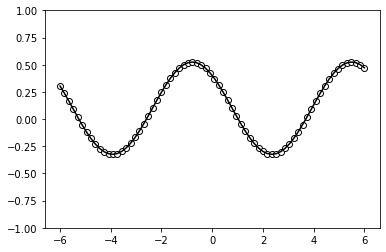

In [8]:
x = np.linspace(-6, 6, 70, requires_grad=False)
target_y = np.array([target_function(x_) for x_ in x], requires_grad=False)

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.show();

## Define the serial quantum model

We now define the quantum model itself:

In [9]:
scaling = 1


dev = qml.device('default.qubit', wires =1)

def S(x):
  """Data encodng circuit block"""
  qml.RX(scaling * x, wires = 0)

def W(theta):
  """Trainable circuit block"""
  qml.Rot(theta[0], theta[1], theta[2], wires=0)

@qml.qnode(dev)

def serial_quantum_model(weights,x):

  for theta in weights[:-1]:
    W(theta)
    S(x)

  # (L+1)'th unitary
  W(weights[-1])

  return qml.expval(qml.PauliZ(wires=0))

You can run the following cell multiple times, each time sampling different weights, and therefore different quantum models.

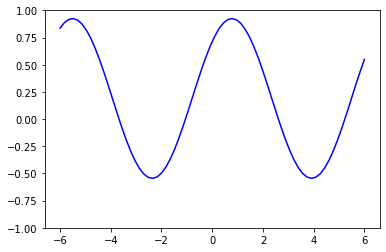

In [10]:
r = 1 # number of times the encoding gets repeated (here equal to the number of layers)
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True) # some random initial weights

x = np.linspace(-6, 6, 70, requires_grad=False)
random_quantum_model_y = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

No matter what weights are picked, the single qubit model for L=1 will always be a sine function of a fixed frequency. The weights merely influence the amplitude, y-shift, and phase of the sine.

This observation is formally derived in Section II.A of the paper.

Let's look at the circuit we just made

In [28]:
print(qml.draw(serial_quantum_model)(weights, x[-1]))

0: ──Rot(4.16,2.06,1.23)──RX(6.00)──Rot(5.42,4.91,0.99)─┤  <Z>


## Fit the model to the targer

The next step is to optimize the weights in order to fit the ground truth

In [29]:
def cost(weights, x, y):
    predictions = [serial_quantum_model(weights, x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.012118291191329796
Cost at step  20: 0.013705000385948182
Cost at step  30: 0.0019061116574147416
Cost at step  40: 0.0032765567424896704
Cost at step  50: 0.0006326300599443154


To continue training, you may just run the above cell again. Once you are happy, you can use the trained model to predict function values, and compare them with the ground truth.

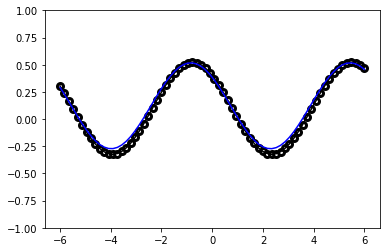

In [30]:
predictions = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show();

Let’s also have a look at the cost during training.

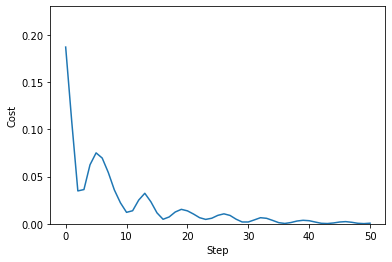

In [31]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.23)
plt.show();

With the initial settings and enough training steps, the quantum model learns to fit the ground truth perfectly. This is expected, since the number of Pauli-rotation-encoding gates and the degree of the ground truth Fourier series are both one.

If the ground truth’s degree is larger than the number of layers in the quantum model, the fit will look much less accurate. And finally, we also need to have the correct scaling of the data: if one of the models changes the scaling parameter (which effectively scales the frequencies), fitting does not work even with enough encoding repetitions.

## Part II: Fitting the Fourier series with parallel Pauli-rotation encoding

Our next task is to repeat the function-fitting experiment for a circuit where the Pauli rotation gate gets repeated $r$ times on different qubits, using a single layer $L=1$.

As shown in the paper, we expect similar results to the serial model: a Fourier series of degree $r$ can only be fitted if there are at least r repetitions of the encoding gate in the quantum model. However, in practice this experiment is a bit harder, since the dimension of the trainable unitaries $W$ grows quickly with the number of qubits.

In the paper, the investigations are made with the assumption that the purple trainable blocks $W$ are arbitrary unitaries. We could use the ArbitraryUnitary template, but since this template requires a number of parameters that grows exponentially with the number of qubits ($4^L−1$ to be precise), this quickly becomes cumbersome to train.

We therefore follow Figure 4 in the paper and use an ansatz for $W$.



![](https://pennylane.ai/qml/_images/parallel_model.png)

## Define the parallel quantum model

The ansatz is PennyLane’s layer structure called `StronglyEntanglingLayers`, and as the name suggests, it has itself a user-defined number of layers (which we will call “ansatz layers” to avoid confusion).

In [32]:
from pennylane.templates import StronglyEntanglingLayers

Let’s have a quick look at the ansatz itself for 3 qubits by making a dummy circuit of 2 ansatz layers:

In [33]:
n_ansatz_layers = 2
n_qubits = 3

dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def ansatz(weights):
    StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.Identity(wires=0))

weights_ansatz = 2 * np.pi * np.random.random(size=(n_ansatz_layers, n_qubits, 3))
print(qml.draw(ansatz, expansion_strategy="device")(weights_ansatz))

0: ──Rot(3.42,4.06,5.87)─╭●────╭X──Rot(2.65,0.88,3.56)─╭●─╭X────┤  <I>
1: ──Rot(3.20,3.56,4.62)─╰X─╭●─│───Rot(0.70,2.86,0.89)─│──╰●─╭X─┤     
2: ──Rot(6.19,1.50,2.51)────╰X─╰●──Rot(4.89,0.55,6.19)─╰X────╰●─┤     


Now we define the actual quantum model


In [34]:
scaling = 1
r = 3

dev = qml.device('default.qubit', wires=r)

def S(x):
    """Data-encoding circuit block."""
    for w in range(r):
        qml.RX(scaling * x, wires=w)

def W(theta):
    """Trainable circuit block."""
    StronglyEntanglingLayers(theta, wires=range(r))


@qml.qnode(dev)
def parallel_quantum_model(weights, x):

    W(weights[0])
    S(x)
    W(weights[1])

    return qml.expval(qml.PauliZ(wires=0))

Again, you can sample random weights and plot the model function:

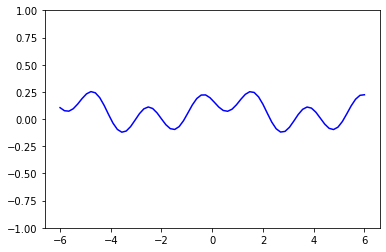

In [35]:
trainable_block_layers = 3
weights = 2 * np.pi * np.random.random(size=(2, trainable_block_layers, r, 3), requires_grad=True)

x = np.linspace(-6, 6, 70, requires_grad=False)
random_quantum_model_y = [parallel_quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show();

## Training the model

Training the model is done exactly as before, but it may take a lot longer this time. We set a default of 25 steps, which you should increase if necessary. Small models of <6 qubits usually converge after a few hundred steps at most—but this depends on your settings.

In [36]:
def cost(weights, x, y):
    predictions = [parallel_quantum_model(weights, x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.009506917011675093
Cost at step  20: 0.0034526368411951923
Cost at step  30: 0.0005179711491547088
Cost at step  40: 0.00043014691439516637
Cost at step  50: 0.00041654998322869947


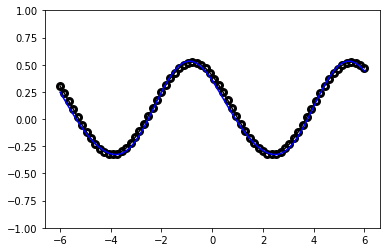

In [37]:
predictions = [parallel_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show();

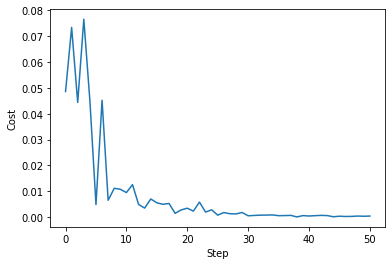

In [38]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.show();

## Part III: Sampling Fourier coefficients

When we use a trainable ansatz above, it is possible that even with enough repetitions of the data-encoding Pauli rotation, the quantum model cannot fit the circuit, since the expressivity of quantum models also depends on the Fourier coefficients the model can create.

Figure 5 in the paper shows Fourier coefficients from quantum models sampled from a model family defined by an ansatz for the trainable circuit block. For this we need a function that numerically computes the Fourier coefficients of a periodic function $f$ with period $2π$.

In [39]:
def fourier_coefficients(f, K):
    """
    Computes the first 2*K+1 Fourier coefficients of a 2*pi periodic function.
    """
    n_coeffs = 2 * K + 1
    t = np.linspace(0, 2 * np.pi, n_coeffs, endpoint=False)
    y = np.fft.rfft(f(t)) / t.size
    return y


## Define your quantum model

Now we need to define a quantum model. This could be any model, using a qubit or continuous-variable circuit, or one of the quantum models from above. We will use a slight derivation of the `parallel_qubit_model()` from above, this time using the `BasicEntanglerLayers` ansatz:

In [40]:
from pennylane.templates import BasicEntanglerLayers

scaling = 1
n_qubits = 4

dev = qml.device('default.qubit', wires=n_qubits)

def S(x):
    """Data encoding circuit block."""
    for w in range(n_qubits):
        qml.RX(scaling * x, wires=w)

def W(theta):
    """Trainable circuit block."""
    BasicEntanglerLayers(theta, wires=range(n_qubits))


@qml.qnode(dev)
def quantum_model(weights, x):

    W(weights[0])
    S(x)
    W(weights[1])

    return qml.expval(qml.PauliZ(wires=0))

It will also be handy to define a function that samples different random weights of the correct size for the model.

In [41]:
n_ansatz_layers = 1

def random_weights():
    return 2 * np.pi * np.random.random(size=(2, n_ansatz_layers, n_qubits))

Now we can compute the first few Fourier coefficients for samples from this model. The samples are created by randomly sampling different parameters using the `random_weights()` function.

In [42]:
n_coeffs = 5
n_samples = 100


coeffs = []
for i in range(n_samples):

    weights = random_weights()

    def f(x):
        return np.array([quantum_model(weights, x_) for x_ in x])

    coeffs_sample = fourier_coefficients(f, n_coeffs)
    coeffs.append(coeffs_sample)

coeffs = np.array(coeffs)
coeffs_real = np.real(coeffs)
coeffs_imag = np.imag(coeffs)

Let’s plot the real vs. the imaginary part of the coefficients. As a sanity check, the c0 coefficient should be real, and therefore have no contribution on the y-axis.

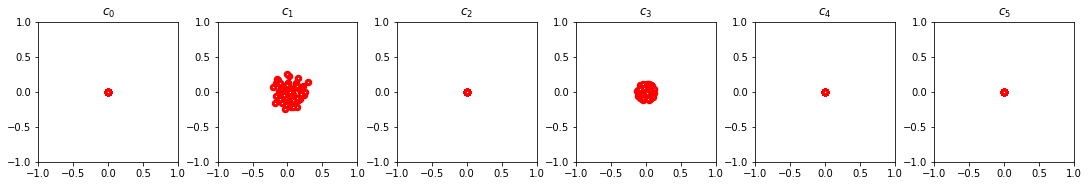

In [43]:
n_coeffs = len(coeffs_real[0])

fig, ax = plt.subplots(1, n_coeffs, figsize=(15, 4))

for idx, ax_ in enumerate(ax):
    ax_.set_title(r"$c_{}$".format(idx))
    ax_.scatter(coeffs_real[:, idx], coeffs_imag[:, idx], s=20,
                facecolor='white', edgecolor='red')
    ax_.set_aspect("equal")
    ax_.set_ylim(-1, 1)
    ax_.set_xlim(-1, 1)


plt.tight_layout(pad=0.5)
plt.show();

Playing around with different quantum models, you will find that some quantum models create different distributions over the coefficients than others. For example BasicEntanglingLayers (with the default Pauli-X rotation) seems to have a structure that forces the even Fourier coefficients to zero, while StronglyEntanglingLayers will have a non-zero variance for all supported coefficients.

Note also how the variance of the distribution decreases for growing orders of the coefficients—an effect linked to the convergence of a Fourier series.


## Continuous-variable model

The paper mentions that a phase rotation in continuous-variable quantum computing has a spectrum that supports all Fourier frequecies. To play with this model, we finally show you the code for a continuous-variable circuit. For example, to see its Fourier coefficients run the cell below, and then re-run the two cells above.

In [44]:
var = 2
n_ansatz_layers = 1
dev_cv = qml.device('default.gaussian', wires=1)

def S(x):
    qml.Rotation(x, wires=0)

def W(theta):
    """Trainable circuit block."""
    for r_ in range(n_ansatz_layers):
        qml.Displacement(theta[0], theta[1], wires=0)
        qml.Squeezing(theta[2], theta[3], wires=0)

@qml.qnode(dev_cv)
def quantum_model(weights, x):
    W(weights[0])
    S(x)
    W(weights[1])
    return qml.expval(qml.X(wires=0))

def random_weights():
    return np.random.normal(size=(2, 5 * n_ansatz_layers), loc=0, scale=var)

In [45]:
n_coeffs = 5
n_samples = 100


coeffs = []
for i in range(n_samples):

    weights = random_weights()

    def f(x):
        return np.array([quantum_model(weights, x_) for x_ in x])

    coeffs_sample = fourier_coefficients(f, n_coeffs)
    coeffs.append(coeffs_sample)

coeffs = np.array(coeffs)
coeffs_real = np.real(coeffs)
coeffs_imag = np.imag(coeffs)

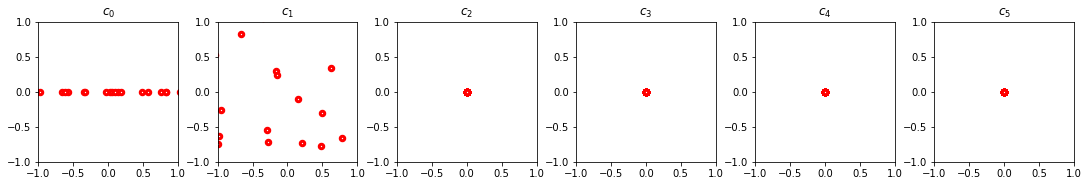

In [46]:
n_coeffs = len(coeffs_real[0])

fig, ax = plt.subplots(1, n_coeffs, figsize=(15, 4))

for idx, ax_ in enumerate(ax):
    ax_.set_title(r"$c_{}$".format(idx))
    ax_.scatter(coeffs_real[:, idx], coeffs_imag[:, idx], s=20,
                facecolor='white', edgecolor='red')
    ax_.set_aspect("equal")
    ax_.set_ylim(-1, 1)
    ax_.set_xlim(-1, 1)


plt.tight_layout(pad=0.5)
plt.show();